In [1]:
import argparse
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
import sys
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

# Set font properties
plt.rcParams.update({
    'font.size': 16,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

In [2]:
df = pd.read_parquet('../tidy_data/bootstrap/full_bs_results.parquet')

In [64]:
df2 = pd.read_parquet('../tidy_data/bootstrap/individual_results/results_130004-0.0_0.parquet')
df2.head()

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,0,10478,0,18,0,0.568225,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,1,10478,0,18,0,0.548870,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
2,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,2,10478,0,18,0,0.564150,...,0.813268,0.066667,0.998285,0.5,0.998285,0.0,1.0,0.0,0.999142,0.0
3,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,3,10478,0,19,0,0.553855,...,0.813268,0.064516,0.998190,0.5,0.998190,0.0,1.0,0.0,0.999094,0.0
4,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,4,10478,0,19,0,0.554149,...,0.813268,0.064516,0.998190,0.5,0.998190,0.0,1.0,0.0,0.999094,0.0


In [65]:
df2.columns

Index(['n_features', 'proteins', 'outcome', 'iteration', 'bootstrap', 'TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos'],
      dtype='object')

In [60]:
df['n_cases'] = df.FN + df.TP
df['n_controls'] = df.FP + df.TN
df['percent_cases'] = 100 * (df['n_cases'] / (df['n_cases'] + df['n_controls']))

In [38]:
df.columns

Index(['n_features', 'outcome', 'iteration', 'bootstrap', 'TN', 'FP', 'FN',
       'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1', 'accuracy',
       'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg', 'rec_pos', 'f1_neg',
       'f1_pos', 'n_cases', 'n_controls', 'percent_cases'],
      dtype='object')

In [82]:
print(set(df.n_features))
df.head()

{100, 5, 1000, 2923, 50, 500}


,n_features,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,avg_prec,...,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos,n_cases,n_controls,percent_cases
0,5,132016,0,0,7796,2663,25,12,0.536583,0.003815,...,0.534856,0.996803,0.004486,0.745387,0.324324,0.852954,0.008850,37,10459,0.352515
1,5,132016,0,1,7791,2668,26,11,0.517674,0.003645,...,0.521103,0.996674,0.004106,0.744909,0.297297,0.852594,0.008100,37,10459,0.352515
2,5,132016,0,2,7798,2661,26,11,0.519421,0.003668,...,0.521438,0.996677,0.004117,0.745578,0.297297,0.853033,0.008121,37,10459,0.352515
3,5,132016,0,3,7793,2666,26,12,0.525707,0.003820,...,0.530445,0.996675,0.004481,0.745100,0.315789,0.852719,0.008837,38,10459,0.362008
4,5,132016,0,4,7797,2662,26,12,0.525775,0.003822,...,0.530636,0.996676,0.004488,0.745482,0.315789,0.852970,0.008850,38,10459,0.362008


In [3]:
df = df.sort_values(by=['best_f1'], ascending=False)

In [50]:
top_rows = df.groupby(['n_features', 'outcome', 'iteration']).median().reset_index()


In [51]:
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)

In [63]:
start = 0
end = start + 50
top_rows.iloc[start:end]

,n_features,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
303729,2923,131286,99,49.5,3783.0,2277.0,828.0,3609.0,0.808099,0.767748,0.397105,0.699500,0.704392,0.719022,0.820321,0.613256,0.624257,0.813387,0.709079,0.699366
265742,1000,131286,42,49.5,4072.0,1988.0,1014.0,3424.0,0.801327,0.759248,0.439742,0.695282,0.713966,0.721647,0.800688,0.632615,0.671947,0.771519,0.730664,0.695149
265736,1000,131286,36,49.5,3708.0,2352.0,824.0,3613.0,0.799691,0.759017,0.391139,0.694796,0.697437,0.713044,0.818132,0.605664,0.611881,0.814289,0.700094,0.694670
265709,1000,131286,9,49.5,4032.0,2028.0,998.0,3439.0,0.801220,0.757465,0.433933,0.694607,0.711775,0.720221,0.801570,0.629128,0.665347,0.775073,0.727199,0.694475
265782,1000,131286,82,49.5,3646.0,2414.0,794.0,3643.0,0.798092,0.755766,0.394331,0.694467,0.694484,0.711370,0.821131,0.601485,0.601650,0.821050,0.694480,0.694342
265705,1000,131286,5,49.5,3639.5,2420.5,793.0,3644.5,0.799441,0.754392,0.389093,0.694257,0.694294,0.711377,0.820912,0.601153,0.600578,0.821296,0.693998,0.694130
265744,1000,131286,44,49.5,3627.0,2433.0,788.0,3649.0,0.798464,0.752191,0.384897,0.693945,0.693150,0.710472,0.821505,0.600000,0.598515,0.822403,0.692535,0.693821
265720,1000,131286,20,49.5,3698.0,2361.0,828.5,3609.0,0.797478,0.752431,0.392402,0.693646,0.696104,0.711838,0.816895,0.604458,0.610332,0.813296,0.698687,0.693520
265753,1000,131286,53,49.5,3810.0,2250.0,892.0,3545.0,0.798947,0.756358,0.412199,0.693052,0.700676,0.713801,0.810304,0.611754,0.628713,0.798963,0.708031,0.692924
265791,1000,131286,91,49.5,3808.0,2252.0,898.0,3539.0,0.794151,0.751521,0.408007,0.692157,0.699914,0.712997,0.809180,0.611082,0.628383,0.797611,0.707358,0.692029


In [53]:
top_rows.shape

(304107, 20)

In [62]:
group_median = df.groupby(['n_features', 'outcome'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos', 'n_cases', 'n_controls', 'percent_cases']].median()

In [31]:
group_median

TN      FP     FN     TP     auroc  avg_prec  \
n_features outcome                                                      
5          130004   10024.0   454.0   17.0    1.0  0.527104  0.002212   
           130008    9317.0   979.0  166.0   35.0  0.591450  0.027335   
           130014    9714.0   770.0   12.0    1.0  0.543972  0.001727   
           130016    9973.0   387.0  126.0   11.0  0.537686  0.016296   
           130018    7719.0  2175.0  395.0  208.0  0.584100  0.079750   
...                     ...     ...    ...    ...       ...       ...   
2923       132532   10267.0   202.0   27.0    1.0  0.481540  0.003593   
           132536    9321.0  1159.0   14.0    3.0  0.453119  0.001825   
           132542   10320.0   152.0   25.0    1.0  0.443063  0.002888   
           132562   10086.0   391.0   20.0    0.0  0.436740  0.001811   
           132574   10406.0    57.0   35.0    0.0  0.473665  0.003810   

                    best_thresh   best_f1  accuracy  balanced_acc  prec_neg  \
n_features outcome                                                            
5          130004      0.560169  0.008386  0.955035      0.504126  0.998252   
           130008      0.568328  0.057524  0.890635      0.539443  0.982517   
           130014      0.476959  0.006042  0.925503      0.498998  0.998765   
           130016      0.600154  0.039640  0.951034      0.521264  0.987572   
           130018      0.534160  0.136382  0.755740      0.558599  0.950873   
...                         ...       ...       ...           ...       ...   
2923       132532      0.521367  0.017241  0.978184      0.508257  0.997377   
           132536      0.219921  0.006780  0.888254      0.532939  0.998500   
           132542      0.444812  0.022346  0.983233      0.512020  0.997583   
           132562      0.341691  0.004854  0.960846      0.481340  0.998021   
           132574      0.571004  0.021739  0.991331      0.497276  0.996648   

                    prec_pos   rec_neg   rec_pos    f1_neg    f1_pos  n_cases  \
n_features outcome                                                              
5          130004   0.001862  0.956671  0.055556  0.976998  0.003697     19.0   
           130008   0.035025  0.904915  0.174129  0.941967  0.055780    201.0   
           130014   0.001137  0.926555  0.076923  0.961306  0.002260     13.0   
           130016   0.024876  0.962645  0.080292  0.974878  0.034387    137.0   
           130018   0.085821  0.780170  0.344942  0.857563  0.135695    603.0   
...                      ...       ...       ...       ...       ...      ...   
2923       132532   0.004926  0.980705  0.035714  0.988971  0.008658     28.0   
           132536   0.002581  0.889408  0.176471  0.940802  0.005089     17.0   
           132542   0.006536  0.985485  0.038462  0.991545  0.011236     26.0   
           132562   0.000000  0.962680  0.000000  0.980032  0.000000     20.0   
           132574   0.000000  0.994552  0.000000  0.995647  0.000000     35.0   

                    n_controls  
n_features outcome              
5          130004      10478.0  
           130008      10296.0  
           130014      10484.0  
           130016      10360.0  
           130018       9894.0  
...                        ...  
2923       132532      10469.0  
           132536      10480.0  
           132542      10471.0  
           132562      10477.0  
           132574      10462.0  

[3642 rows x 18 columns]

[None]

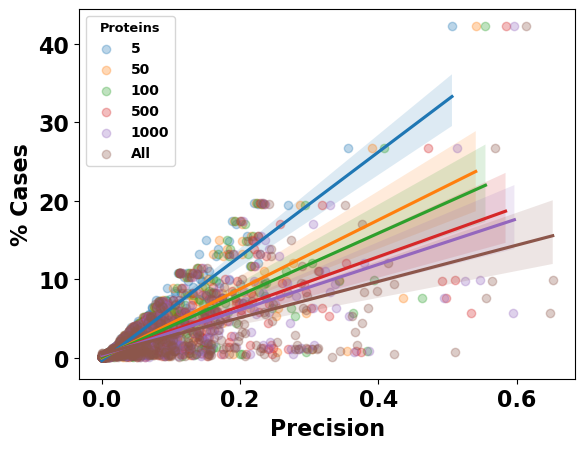

In [81]:
pdf = group_median[group_median.auroc >= 0.5]

xlabel_dict = {'auroc': 'AUROC', 'prec_pos': 'Precision', 'avg_prec': "Average Precision", 'f1_pos': 'F1 Positive'}
ylabel_dict = {'percent_cases': '% Cases'}
x_col = 'prec_pos'
y_col = 'percent_cases'
sk = {'alpha': 0.3}
sns.regplot(data=pdf.loc[(5)], x=x_col, y=y_col, scatter_kws=sk, label='5' )
sns.regplot(data=pdf.loc[(50)], x=x_col, y=y_col, scatter_kws=sk, label='50')
sns.regplot(data=pdf.loc[(100)], x=x_col, y=y_col, scatter_kws=sk, label='100')
sns.regplot(data=pdf.loc[(500)], x=x_col, y=y_col, scatter_kws=sk, label='500')
sns.regplot(data=pdf.loc[(1000)], x=x_col, y=y_col, scatter_kws=sk, label='1000')
sns.regplot(data=pdf.loc[(2923)], x=x_col, y=y_col, scatter_kws=sk, label='All')
legend = plt.legend(title="Proteins", fontsize=10)
plt.ylabel(ylabel_dict[y_col], fontweight='bold')
plt.xlabel(xlabel_dict[x_col], fontweight='bold')
plt.setp(legend.get_title(),fontsize='xx-small')


<Axes: xlabel='auroc', ylabel='avg_prec'>

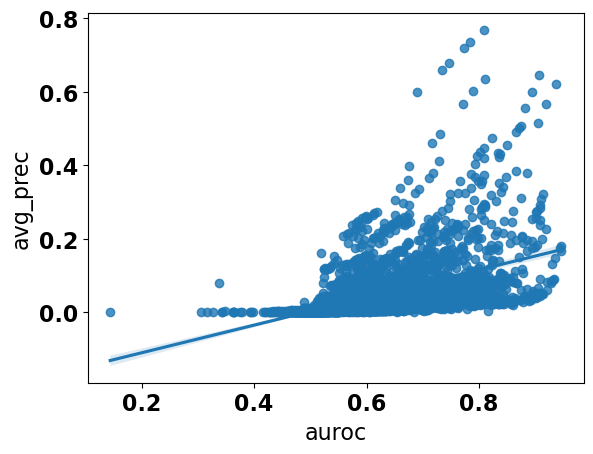

In [56]:
sns.regplot(x=group_median.auroc, y=group_median.avg_prec)

In [72]:
group_median[group_median.percent_cases > 20]

TN      FP      FN      TP     auroc  avg_prec  \
n_features outcome                                                       
5          130814   3805.0  3880.0   656.0  2155.5  0.674663  0.398674   
           131286   2392.0  3668.0   679.0  3758.0  0.689695  0.597718   
50         130814   4455.0  3230.0   755.5  2056.0  0.715297  0.459271   
           131286   2983.0  3077.0   781.0  3656.0  0.733175  0.659775   
100        130814   4738.0  2947.0   786.0  2025.0  0.730289  0.484145   
           131286   3148.0  2912.0   812.0  3625.0  0.746779  0.679065   
500        130814   5608.0  2077.5   941.0  1870.0  0.770742  0.566516   
           131286   3555.0  2505.0   883.0  3554.0  0.772373  0.718169   
1000       130814   5958.0  1728.0   991.0  1821.0  0.789865  0.602085   
           131286   3655.0  2405.0   890.0  3547.0  0.784209  0.735775   
2923       130814   6322.0  1363.0  1017.0  1795.0  0.809879  0.633928   
           131286   3783.0  2277.0   828.0  3609.0  0.808099  0.767748   

                    best_thresh   best_f1  accuracy  balanced_acc  prec_neg  \
n_features outcome                                                            
5          130814      0.462181  0.485386  0.567591      0.628440  0.852512   
           131286      0.383841  0.632957  0.586453      0.621277  0.778686   
50         130814      0.466189  0.509443  0.621225      0.656974  0.856774   
           131286      0.393675  0.653353  0.629608      0.656182  0.791549   
100        130814      0.471905  0.521029  0.645899      0.668589  0.857934   
           131286      0.400864  0.660244  0.645613      0.668095  0.794737   
500        130814      0.500154  0.555106  0.711727      0.698631  0.857186   
           131286      0.408941  0.674832  0.674478      0.690985  0.800364   
1000       130814      0.512957  0.573377  0.741640      0.711845  0.857185   
           131286      0.410694  0.682281  0.687339      0.701998  0.803994   
2923       130814      0.531349  0.601558  0.773269      0.730480  0.861425   
           131286      0.397105  0.699500  0.704392      0.719022  0.820321   

                    prec_pos   rec_neg   rec_pos    f1_neg    f1_pos  n_cases  \
n_features outcome                                                              
5          130814   0.356432  0.495120  0.766673  0.626366  0.485223   2812.0   
           131286   0.506545  0.394719  0.846969  0.524038  0.632845   4437.0   
50         130814   0.390558  0.579701  0.731282  0.690989  0.509258   2812.0   
           131286   0.540921  0.492244  0.823980  0.605949  0.653231   4437.0   
100        130814   0.408903  0.616526  0.720384  0.718290  0.520843   2812.0   
           131286   0.555013  0.519472  0.816993  0.628571  0.660126   4437.0   
500        130814   0.472489  0.729686  0.665244  0.787547  0.554897   2812.0   
           131286   0.584069  0.586634  0.800992  0.675450  0.674709   4437.0   
1000       130814   0.514265  0.775176  0.647582  0.814923  0.573145   2812.0   
           131286   0.596863  0.603135  0.799414  0.690055  0.682156   4437.0   
2923       130814   0.568373  0.822642  0.638336  0.841587  0.601324   2812.0   
           131286   0.613256  0.624257  0.813387  0.709079  0.699366   4437.0   

                    n_controls  percent_cases  
n_features outcome                             
5          130814       7685.0      26.788606  
           131286       6060.0      42.269220  
50         130814       7685.0      26.788606  
           131286       6060.0      42.269220  
100        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
500        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
1000       130814       7685.0      26.788606  
           131286       6060.0      42.269220  
2923       130814       7685.0      26.788606  
           131286       6060.0      42.269220

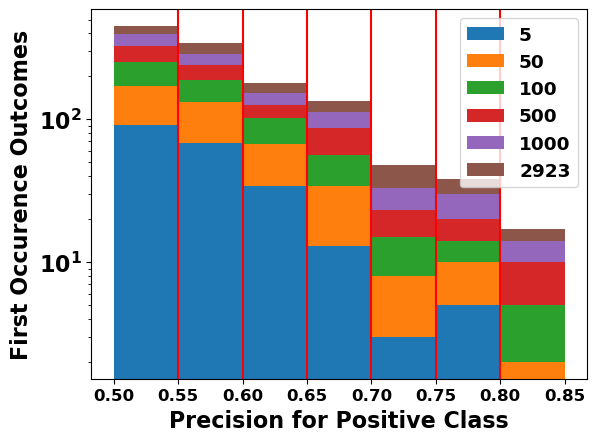

In [106]:
marker_range = np.arange(0.5,0.9,0.05)
metric = 'AUROC'
newcols = []
for nf in [5, 50, 100, 500, 1000, 2923]:
 newcols.append(dfres[dfres.n_features == nf][metric])

df_newcols = pd.concat(newcols, axis=1)
df_newcols.columns = [str(x) for x in [5, 50, 100, 500, 1000, 2923]]

plt.hist(df_newcols, bins = marker_range, 
    histtype='bar', stacked=True, label = [5, 50, 100, 500, 1000, 2923], log=True)
plt.legend(fontsize='small')
plt.ylabel("First Occurence Outcomes", weight='bold')
plt.xlabel("Precision for Positive Class", weight='bold')

# Adjust font properties for x-axis tick labels
plt.tick_params(axis='x', labelsize=12)  # Set font size for x-axis tick labels

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=900, color='red')

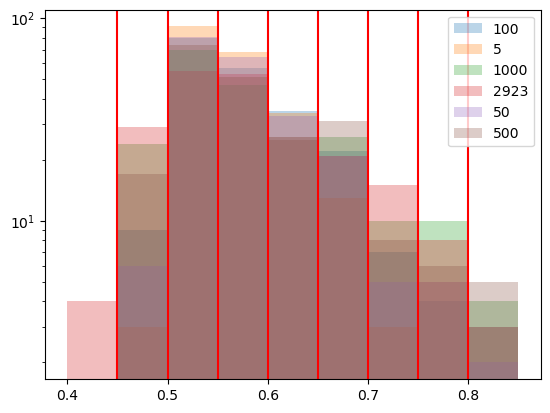

In [59]:
for nf in [5, 50, 100, 500, 1000, 2923]:
    plt.hist(dfres[dfres.n_features == nf].AUROC, bins=marker_range, log=True, alpha=0.3, label=nf)
    plt.legend()

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=500, color='red')
    # plt.vlines(0.6, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.7, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.8, ymin=0.5, ymax=500, color='k')